In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx

from networkx.readwrite import json_graph
import json

import pandas

import copy
import random

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def get_connected_graph(net):
  # Get a list of connected components
  components = list(nx.connected_components(net))
  # Find the largest connected component
  largest_component = max(components, key=len)
  # Create a new graph containing only the largest component
  net_largest = net.subgraph(largest_component)
  # print warning
  if not nx.is_connected(net_largest):
    print("Graph is not connected")
  return(net_largest)



def create_net(filename):
  adjmat = pd.read_csv(filename)
  adjmat.rename(columns=lambda x: x.replace('.', '|'), inplace=True)
  # Create an empty graph
  tmpG= nx.Graph()

  # Iterate over the rows and columns of the DataFrame to add edges with weights
  for row in range(len(adjmat)):
    # print(adjmat.iloc[row, 0])
    source = adjmat.iloc[row, 0]
    target = adjmat.iloc[row, 1]
    weight = adjmat.iloc[row, 2]

    # Skip diagonal and negative edges
    if source != target and weight > 0:
        tmpG.add_edge(source, target, weight=weight)

  # get connected graph:
  net = get_connected_graph(tmpG)
  return(net)

In [ ]:
# METACARDIS
CAD_MC = create_net("metaCardis_cad_edges.csv")
HF_MC = create_net("metaCardis_hf_edges.csv")
IGT_MC = create_net("metaCardis_igt_edges.csv")
T2D_MC = create_net("metaCardis_t2d_edges.csv")
CTL_MC = create_net("metaCardis_control_edges.csv")
MS_MC = create_net("metaCardis_ms_edges.csv")

# HMP
IGT_HMP = create_net("hmp_igt_edges.csv")
CTL_HMP = create_net("hmp_control_edges.csv")

# KARLSSON
IGT_K = create_net("karlsson_igt_edges.csv")
T2D_K = create_net("karlsson_t2d_edges.csv")
CTL_K = create_net("karlsson_control_edges.csv")

# JIEZ
ACVD_JZ = create_net("jiez_acvd_edges.csv")
CTL_JZ = create_net("jiez_control_edges.csv")

# QINJ
T2D_QJ = create_net("qinj_t2d_edges.csv")
CTL_QJ = create_net("qinj_control_edges.csv")

In [ ]:
CAD_col = "#fde725"
HF_col = "#90d743"
IGT_col = "#35b779"
T2D_col = "#21918c"
ACVD_col = "#31688e"
MS_col = "#443983"
CTL_col = "#440154"

In [ ]:
disease_dict = {"CAD": {"color" : CAD_col, "linestyle" : "solid"},
            "HF": {"color" : HF_col, "linestyle" : "solid"},
            "IGT": {"color" : IGT_col, "linestyle" : "solid"},
            "T2D": {"color" : T2D_col, "linestyle" : "solid"},
            "ACVD": {"color" : ACVD_col, "linestyle" : "solid"},
            "MS": {"color" : MS_col, "linestyle" : "solid"},
            "CTL": {"color" : CTL_col, "linestyle" : "dashed"}}

In [ ]:
study_dict = {"MetaCardis": {"CAD" : CAD_MC,
                             "HF" : HF_MC,
                             "IGT" : IGT_MC,
                             "T2D" : T2D_MC,
                             "MS" : MS_MC,
                             "CTL" : CTL_MC},
              "HMP" : {"IGT" : IGT_HMP, "CTL" : CTL_MC},
              "Karlsson" : {"IGT": IGT_K, "T2D" : T2D_K,
                            "CTL" : CTL_K},
              "JieZ" : {"ACVD" : ACVD_JZ, "CTL" : CTL_JZ},
              "QinJ" : {"T2D" : T2D_QJ, "CTL" : CTL_QJ}}

# Ataques a la red

## Ataque aleatorio
La función que utilizamos hace lo siguiente:
1. Selecciona un nodo aleatorio dentro de la lista de nodos
2. Elimina el nodo del grafo
3. Obtiene el tamaño del mayor componente conexo

Después visualizamos el tamaño de la mayor componente conexa en función del número de nodos eliminados.

In [ ]:
def remove_random_node(g, n):
  lcc_sizes = []
  for i in range(n):
    node = random.choice(list(g.nodes()))
    g.remove_node(node)
    try:
      lcc_size = len(max(nx.connected_components(g), key=len))
    except:
      lcc_size = 0
    lcc_sizes.append(lcc_size)
  return(lcc_sizes)

In [ ]:
def plot_attack(net, lcc_sizes,
                       col = "black",
                       line = "solid",
                       lab = "Network"):
  x_vals_net = [i/net.order() for i in range(net.order())]
  net_rand_to_plot = [i/net.order() for i in lcc_sizes]
  plt.plot(x_vals_net, net_rand_to_plot,
           color = col, linestyle = line, label = lab)

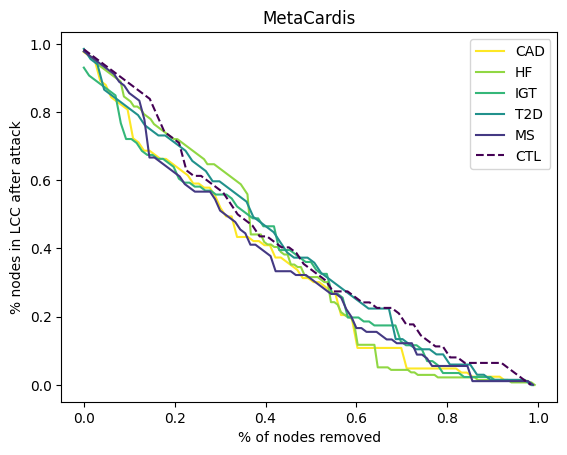

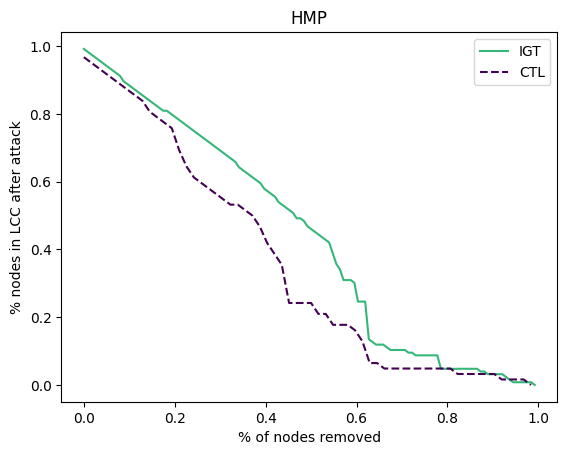

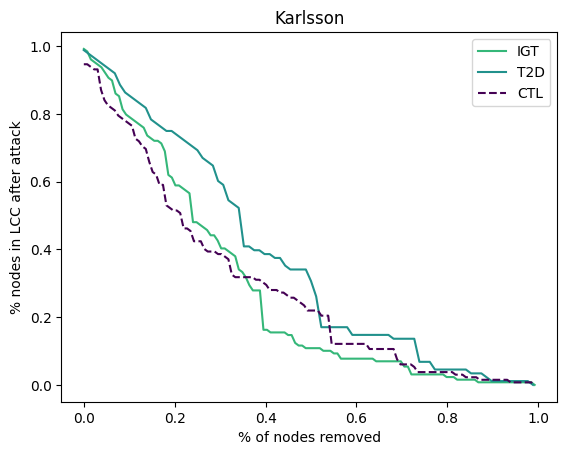

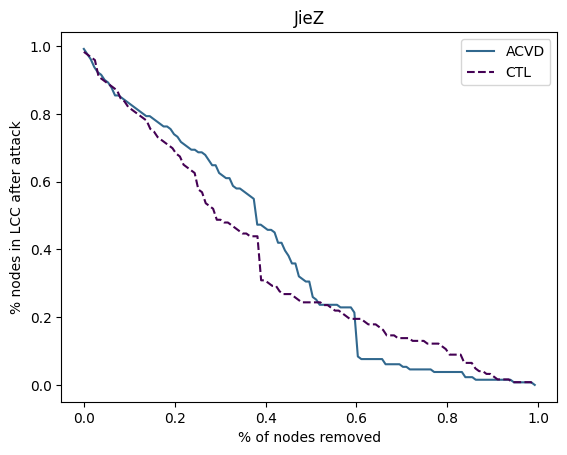

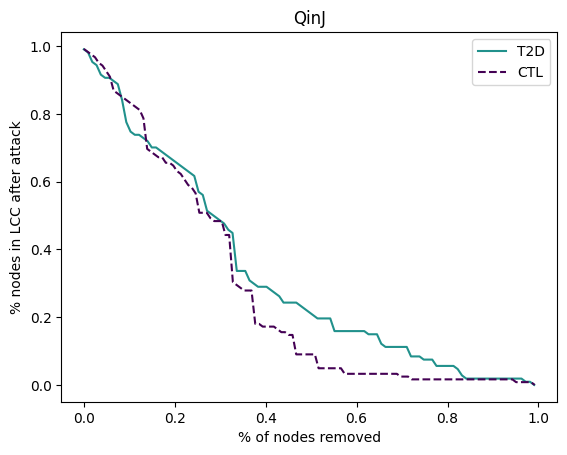

In [ ]:
for study in study_dict:
  for disease in study_dict[study]:

    net_kk = nx.Graph(study_dict[study][disease]) # copia para no cargarnos el original
    net_lcc_sizes_random = remove_random_node(net_kk, net_kk.order())

    plot_attack(study_dict[study][disease],
                net_lcc_sizes_random,
                disease_dict[disease]["color"],
                disease_dict[disease]["linestyle"],
                disease)
  plt.ylabel("% nodes in LCC after attack")
  plt.xlabel("% of nodes removed")
  plt.legend()
  plt.title(study)
  plt.show();

## Ataque dirigido por grado: ataque a los hubs

Ahora necesitaremos llevar a cabo los siguientes pasos:
1. Calcular el grado de todos los nodos.
2. Ordenar los nodos en función de su grado
3. Seleccionar el nodo con el valor más alto.
4. Eliminar el nodo del grafo.
5. Obtener el tamaño del mayor componente conexo.


In [ ]:
def attack_degree(g, n):
  lcc_sizes = []
  for i in range(n):
    node = max(g.degree, key = lambda x: x[1])[0]
    g.remove_node(node)
    try:
      lcc_size = len(max(nx.connected_components(g), key=len))
    except:
      lcc_size = 0
    lcc_sizes.append(lcc_size)
  return(lcc_sizes)

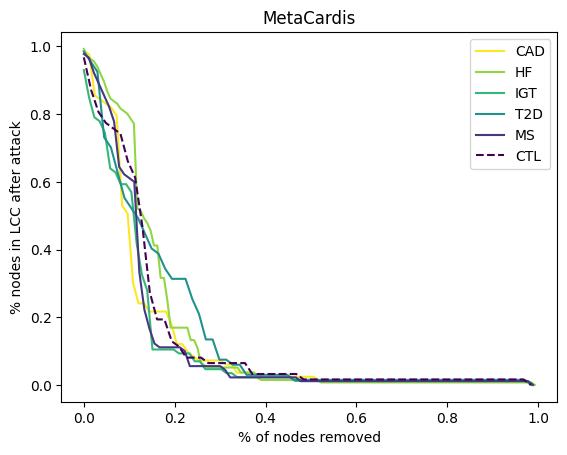

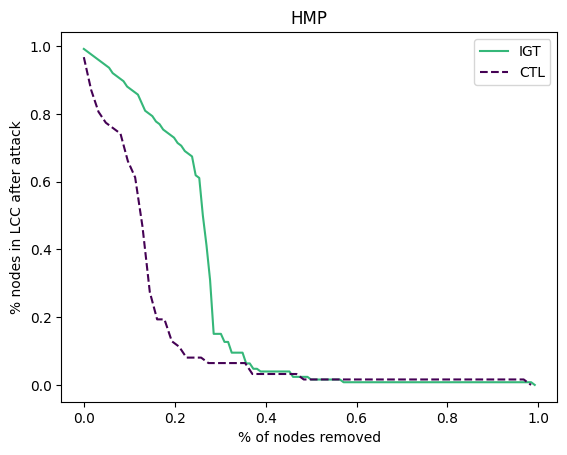

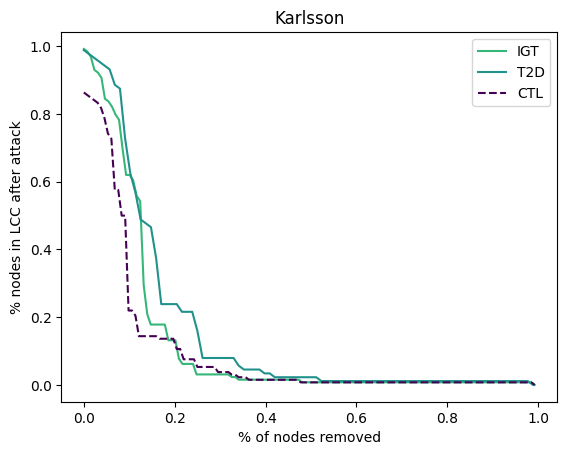

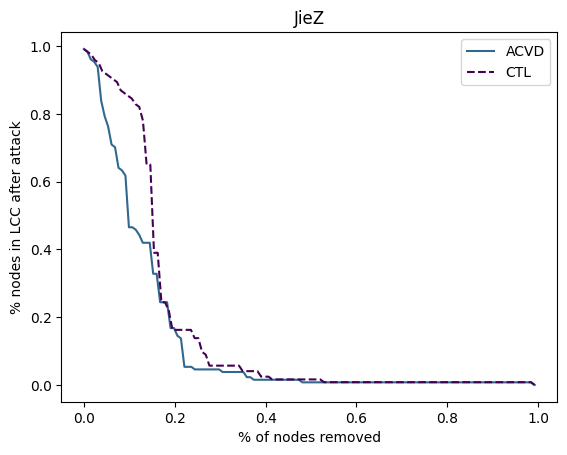

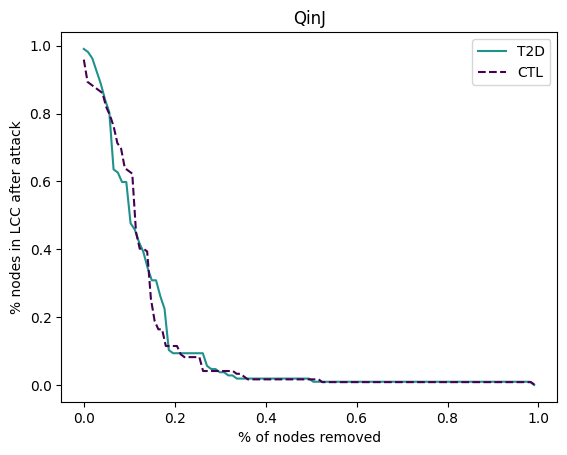

In [ ]:
for study in study_dict:
  for disease in study_dict[study]:

    net_kk = nx.Graph(study_dict[study][disease]) # copia para no cargarnos el original
    net_lcc_sizes_degree = attack_degree(net_kk, net_kk.order())

    plot_attack(study_dict[study][disease],
                net_lcc_sizes_degree,
                disease_dict[disease]["color"],
                disease_dict[disease]["linestyle"],
                disease)
  plt.ylabel("% nodes in LCC after attack")
  plt.xlabel("% of nodes removed")
  plt.legend()
  plt.title(study)
  plt.show();

## Ataque dirigido por betweenness: ataque a los bottlenecks



Ahora necesitaremos llevar a cabo los siguientes pasos:
1. Calcular el _betweenness_ de todos los nodos.
2. Ordenar los nodos en función de su _betweenness_
3. Seleccionar el nodo con el valor más alto.
4. Eliminar el nodo del grafo.
5. Obtener el tamaño del mayor componente conexo.

In [ ]:
def attack_betweenness(g, n, verbose = False):
  lcc_sizes = []
  for i in range(n):
    if verbose:
      print(i)
    bet = nx.betweenness_centrality(g)
    node = max(bet, key=bet.get)
    g.remove_node(node)
    try:
      lcc_size = len(max(nx.connected_components(g), key=len))
    except:
      lcc_size = 0
    lcc_sizes.append(lcc_size)
  return(lcc_sizes)

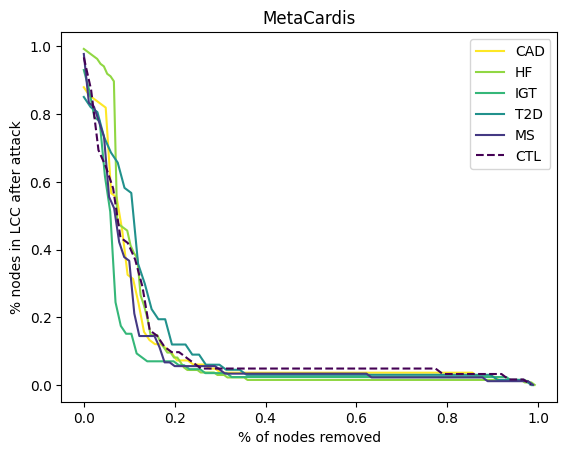

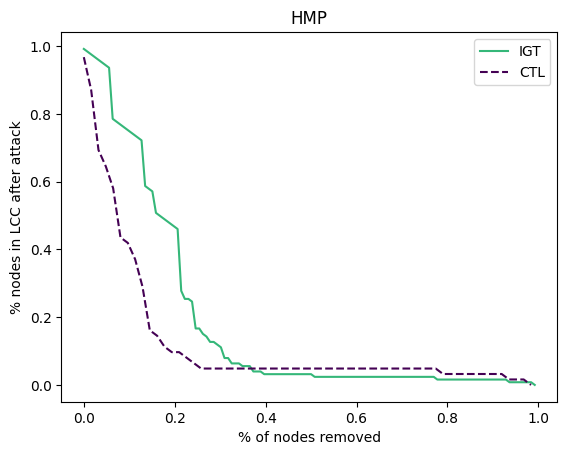

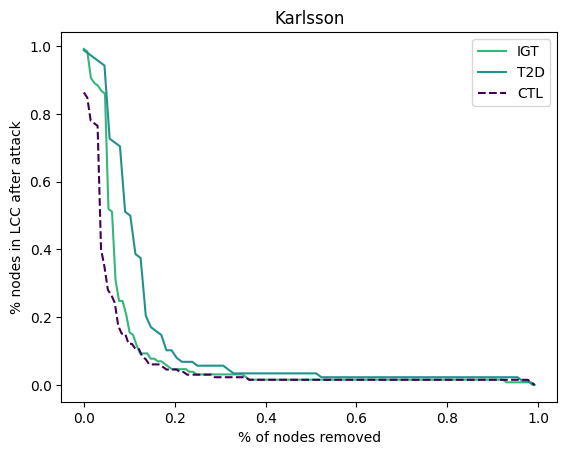

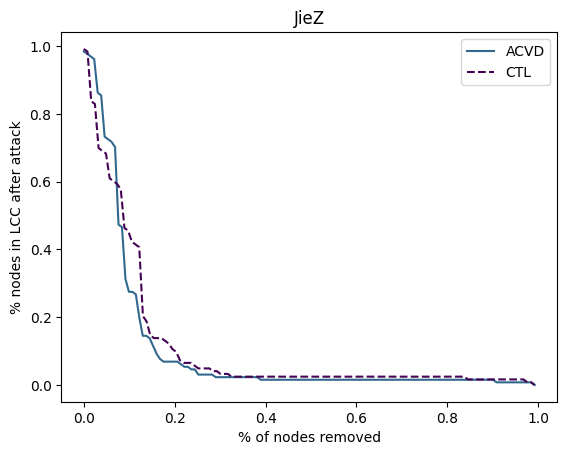

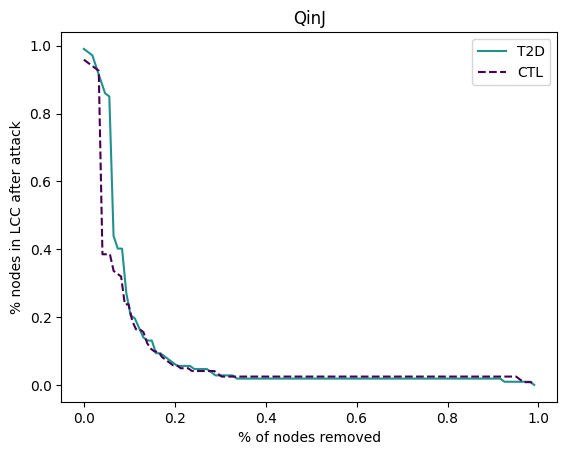

In [ ]:
for study in study_dict:
  for disease in study_dict[study]:

    net_kk = nx.Graph(study_dict[study][disease]) # copia para no cargarnos el original
    net_lcc_sizes_betweenness = attack_betweenness(net_kk, net_kk.order())

    plot_attack(study_dict[study][disease],
                net_lcc_sizes_betweenness,
                disease_dict[disease]["color"],
                disease_dict[disease]["linestyle"],
                disease)
  plt.ylabel("% nodes in LCC after attack")
  plt.xlabel("% of nodes removed")
  plt.legend()
  plt.title(study)
  plt.show();

# Un gráfico por condición

In [ ]:
study_dict_2 = {'MetaCardis': {'color': '#fde725', 'linestyle': 'solid'},
 'HMP': {'color': '#7ad151', 'linestyle': 'solid'},
 'Karlsson': {'color': '#22a884', 'linestyle': 'solid'},
 'JieZ': {'color': '#414487', 'linestyle': 'solid'},
 'QinJ': {'color': '#440154', 'linestyle': 'solid'},
  'CTL_MC': {'color': '#fde725', 'linestyle': 'dashed'},
 'CTL_HMP': {'color': '#7ad151', 'linestyle': 'dashed'},
 'CTL_K': {'color': '#22a884', 'linestyle': 'dashed'},
 'CTL_JZ': {'color': '#414487', 'linestyle': 'dashed'},
 'CTL_QJ': {'color': '#440154', 'linestyle': 'dashed'}}

In [ ]:
disease_dict_2 = {"CAD": {"MetaCardis" : CAD_MC,
                          "CTL_MC" : CTL_MC},
                  "HF" : {"MetaCardis" : HF_MC,
                          "CTL_MC" : CTL_MC},
                  "MS" : {"MetaCardis" : MS_MC,
                          "CTL_MC" : CTL_MC},
                  "IGT" : {"MetaCardis" : IGT_MC,
                           "HMP" : IGT_HMP,
                           "Karlsson" : IGT_K,
                          "CTL_MC" : CTL_MC,
                           "CTL_HMP" : CTL_HMP,
                           "CTL_K" : CTL_K},
                  "T2D" : {"MetaCardis" : T2D_MC,
                           "Karlsson" : T2D_K,
                           "QinJ" : T2D_QJ,
                           "CTL_MC" : CTL_MC,
                           "CTL_K" : CTL_K,
                           "CTL_QJ" : CTL_QJ
                           },
                  "ACVD" : {"JieZ" : ACVD_JZ,
                            "CTL_JZ" : CTL_JZ}}

# Grado

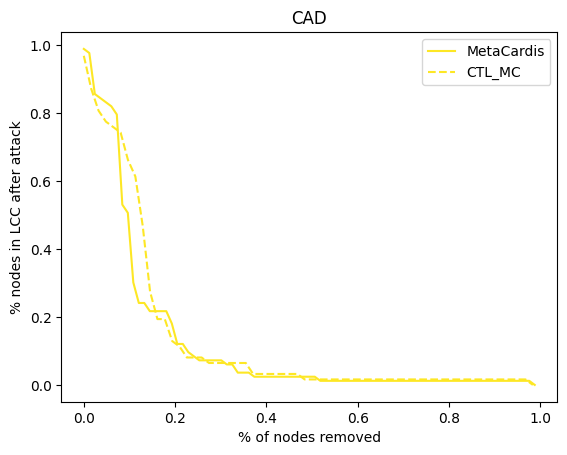

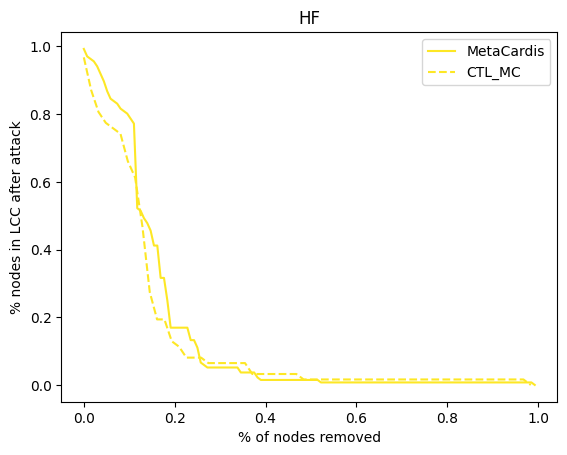

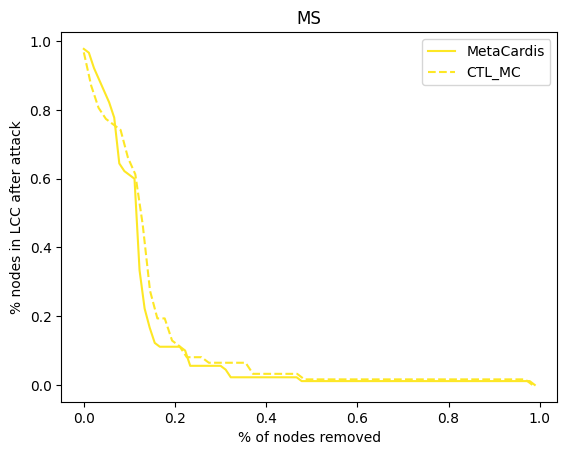

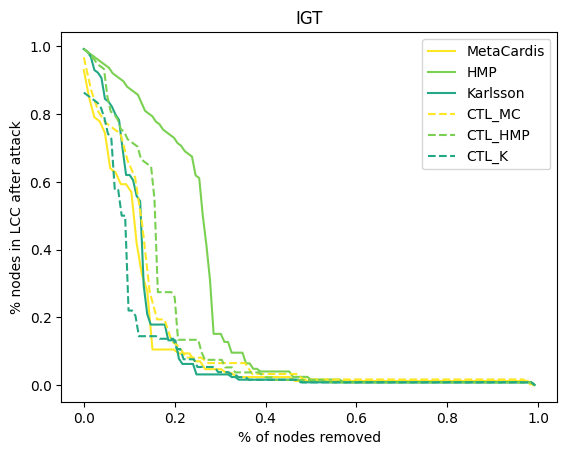

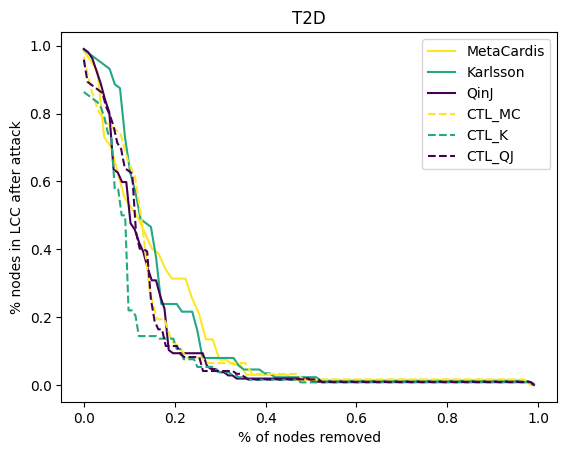

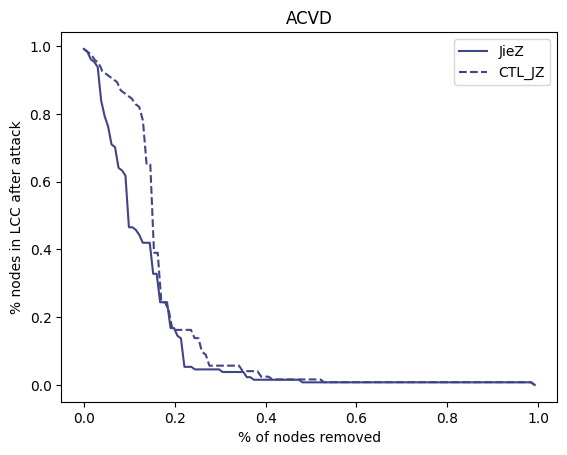

In [ ]:
for disease in disease_dict_2:
  for study in disease_dict_2[disease]:

    net_kk = nx.Graph(disease_dict_2[disease][study])
    net_lcc_sizes_degree = attack_degree(net_kk, net_kk.order())

    plot_attack(disease_dict_2[disease][study],
                net_lcc_sizes_degree,
                study_dict_2[study]["color"],
                study_dict_2[study]["linestyle"],
                study)
  plt.ylabel("% nodes in LCC after attack")
  plt.xlabel("% of nodes removed")
  plt.legend()
  plt.title(disease)
  plt.show();

## Betweenness

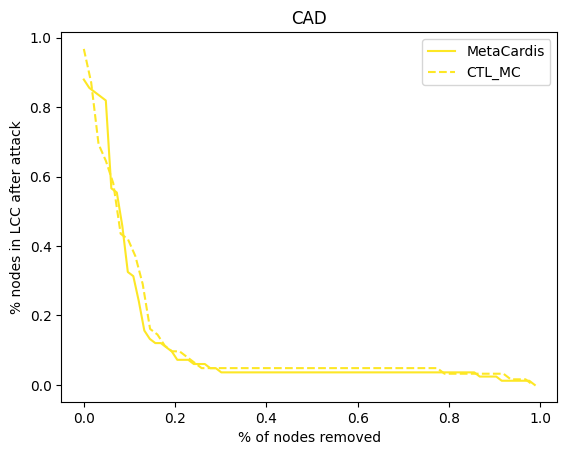

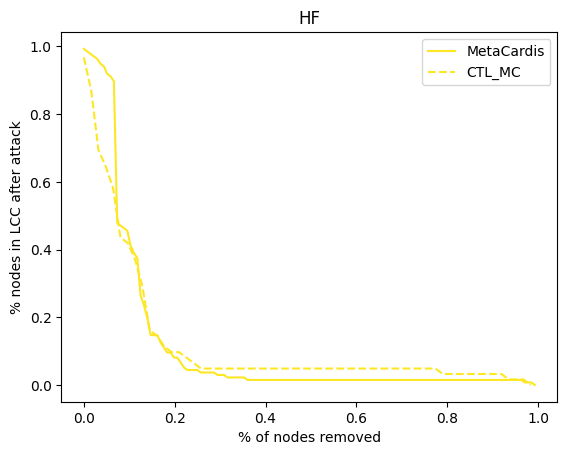

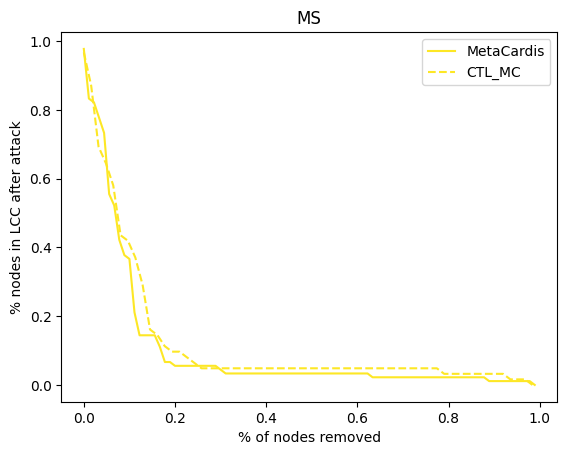

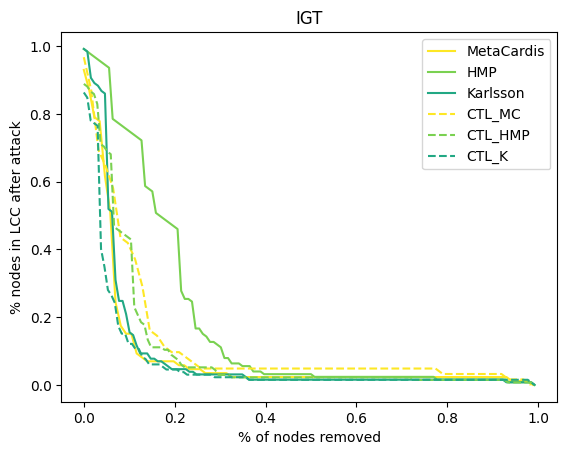

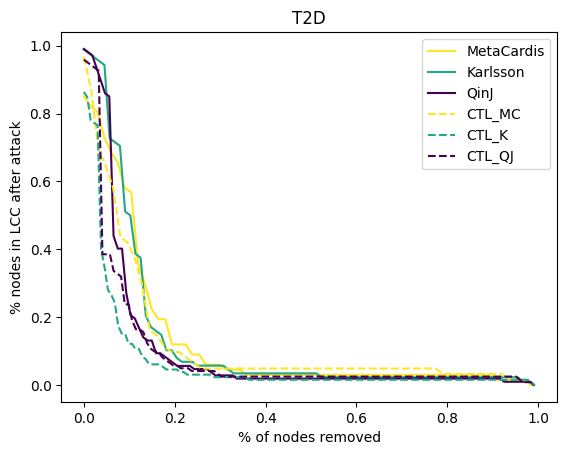

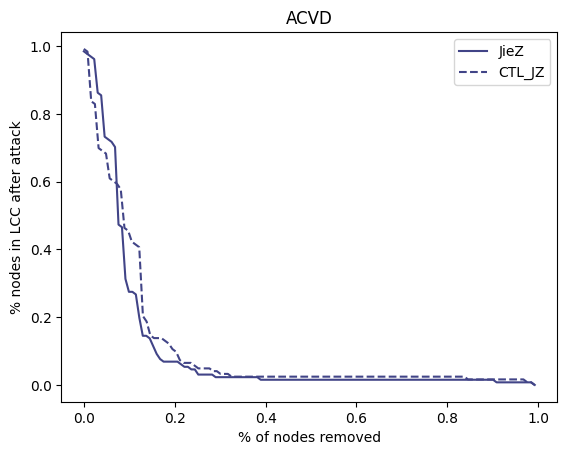

In [ ]:
for disease in disease_dict_2:
  for study in disease_dict_2[disease]:

    net_kk = nx.Graph(disease_dict_2[disease][study])
    net_lcc_sizes_betweenness = attack_betweenness(net_kk, net_kk.order())

    plot_attack(disease_dict_2[disease][study],
                net_lcc_sizes_betweenness,
                study_dict_2[study]["color"],
                study_dict_2[study]["linestyle"],
                study)
  plt.ylabel("% nodes in LCC after attack")
  plt.xlabel("% of nodes removed")
  plt.legend()
  plt.title(disease)
  plt.show();